In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# set Randomseed
RSEED = 42

# import needed functions
from modeling.processing import *

# Load the TensorBoard notebook extension
%load_ext tensorboard



2.8.0


In [2]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [3]:
# load the dataset and use the first 500k (to be faster on testruns)

dataset = pd.read_csv('../data/yelp_dataset/review_1819.csv')
dataset = dataset[:500000]


In [4]:
# reduce dataset to text and rating
dataset = dataset[['text', 'stars']]

In [5]:
# filter for only english reviews
dataset = language_processing(dataset)

#remove the language line used for filtering
dataset.drop('language', axis=1, inplace=True)

In [6]:
# define stopwords and symbols to be deleted
stopwords = nltk.corpus.stopwords.words('english')
punctuation = ['"', '(', ')', '-', '$', ',', '+', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', "'"]

#define function for textcleaning
def clean_text(text):   
    cleaned_text = "".join(u for u in text if u not in punctuation)
    cleaned_text = cleaned_text.lower()
    return cleaned_text

In [7]:
#apply function for textcleaning and make sure everything looks as planned
dataset["text"] = dataset["text"].apply(clean_text)
dataset

,text,stars
0,if you decide to eat here just be aware it is ...,3.0
1,i was really between and stars for this one....,4.0
2,my boyfriend and i tried this deli for the fir...,5.0
4,the cafe was extremely cute. we came at am and...,4.0
5,ive only had the cannolis here but they are aw...,5.0
...,...,...
499995,honestly i thought i would really love this pl...,1.0
499996,spent an evening eating a mexican repast of my...,4.0
499997,we love the food and we go to this location a ...,1.0
499998,we are so happy about this place just opening ...,5.0


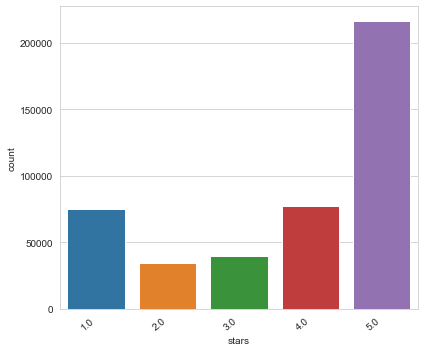

In [8]:
# plot the data distribution
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='stars', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [9]:
# define feature and target
review = dataset["text"].values
stars = dataset[["stars"]].values

# split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(review, stars, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(354530,) (354530, 1)
(88633,) (88633, 1)


In [10]:
#apply tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 138403 unique tokens.


In [11]:
# transform feature to tensors and pad for better comparison
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of train tensor:', train_padded.shape)
print('Shape of validation tensor:', test_padded.shape)

Shape of train tensor: (354530, 200)
Shape of validation tensor: (88633, 200)


In [12]:
# encode the target variable
encode = OneHotEncoder()

training_labels = encode.fit_transform(y_train)
test_labels = encode.transform(y_test)


In [13]:
# make sure everything looks good
print(train_padded.shape)
print(test_labels.shape)
print(test_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(test_padded))
print(type(training_labels))
print(type(test_labels))

(354530, 200)
(88633, 5)
(88633, 200)
(354530, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [14]:
# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
test_labels = test_labels.toarray()

print(type(training_labels))
print(type(test_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-23 12:52:36.914571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-23 12:52:36.915726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


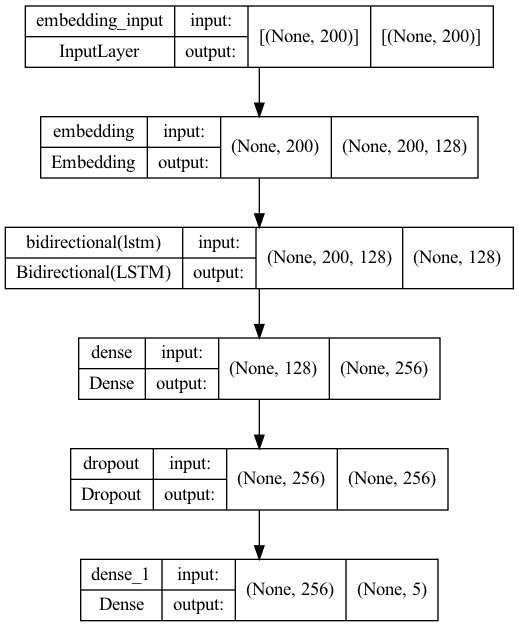

In [15]:
# initiate and define the model
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# show the model structure
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [16]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# save history in tensorboard
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [18]:
# set parameters and train the model
epochs = 8
batch_size = 128

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])

Epoch 1/8


2022-08-23 12:52:38.508800: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-23 12:52:41.079554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 12:52:41.578667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 12:52:41.614936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 12:52:43.990100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 12:52:44.016266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2216/2216 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.6928

2022-08-23 12:59:59.797940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 13:00:00.306268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 13:00:00.517613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2216/2216 [==============================] - 478s 212ms/step - loss: 0.7581 - accuracy: 0.6928 - val_loss: 0.6858 - val_accuracy: 0.7182
Epoch 2/8
2216/2216 [==============================] - 448s 202ms/step - loss: 0.6339 - accuracy: 0.7382 - val_loss: 0.6641 - val_accuracy: 0.7218
Epoch 3/8
2216/2216 [==============================] - 464s 209ms/step - loss: 0.5736 - accuracy: 0.7633 - val_loss: 0.6807 - val_accuracy: 0.7273
Epoch 4/8
2216/2216 [==============================] - 487s 220ms/step - loss: 0.5153 - accuracy: 0.7888 - val_loss: 0.7377 - val_accuracy: 0.6994
Epoch 5/8
2216/2216 [==============================] - 506s 228ms/step - loss: 0.4565 - accuracy: 0.8161 - val_loss: 0.7814 - val_accuracy: 0.7088
Epoch 6/8
2216/2216 [==============================] - 502s 227ms/step - loss: 0.3965 - accuracy: 0.8422 - val_loss: 0.8415 - val_accuracy: 0.7117
Epoch 7/8
2216/2216 [==============================] - 563s 254ms/step - loss: 0.3453 - accuracy: 0.8654 - val_loss: 1.0137 - va

In [19]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_padded, test_labels, batch_size=128)

Evaluate on test data
693/693 [==============================] - 63s 90ms/step - loss: 1.0485 - accuracy: 0.7019


In [20]:
# predict labels and transform form for confusion matrix
pred_labels = model.predict(test_padded)
pred_labels_eval = tf.math.softmax(pred_labels)
pred_labels_eval = np.argmax(pred_labels, axis=1)
test_labels_eval = np.argmax(test_labels, axis=1)


2022-08-23 14:02:25.281763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 14:02:25.643889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 14:02:25.716152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

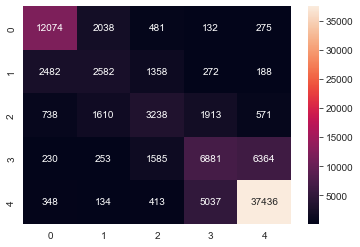

In [21]:
sns.heatmap(tf.math.confusion_matrix(test_labels_eval, pred_labels_eval), annot=True, fmt='g')

In [22]:
# show the classification report
print(classification_report(pred_labels, test_labels))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets

In [ ]:
#look at tensorboard
%tensorboard --logdir logs/fit